In [1]:
%pip install prometheus-api-client

Note: you may need to restart the kernel to use updated packages.


In [161]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
from prometheus_api_client import PrometheusConnect, MetricSnapshotDataFrame, MetricRangeDataFrame
from prometheus_api_client.utils import parse_datetime
from IPython.display import clear_output
from datetime import timedelta
import matplotlib.pyplot as plt 
import matplotlib.animation as animation
import seaborn as sns
import pandas as pd

In [6]:
prom = PrometheusConnect(url="http://192.168.39.81:32471", disable_ssl=True)

KeyboardInterrupt: 

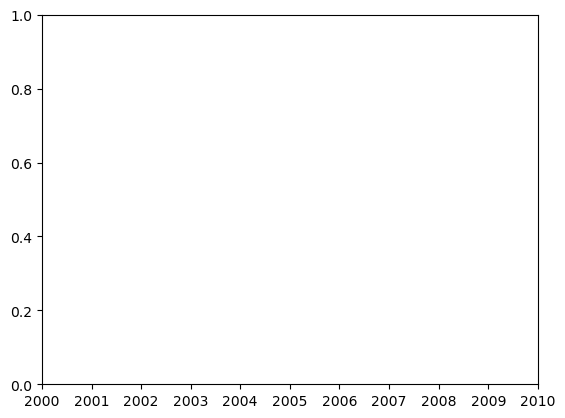

In [15]:
while True:
    clear_output(wait=True)
    start_time = parse_datetime("5m")
    end_time = parse_datetime("now")
    metric_df = MetricRangeDataFrame(prom.custom_query_range('rate(container_cpu_usage_seconds_total{namespace="wordpress"}[1m])*100',start_time, end_time, 1.00))

    sns.lineplot(x='timestamp', y='value', data=metric_df)
    plt.pause(0.05)

plt.show()

### Building panel data
The following code builds a panel of time series data to later be integrated with fault data.

In [244]:
df_list = []

def get_metric_data():
    #Specify time interval
    start_time = parse_datetime("5m")
    end_time = parse_datetime("now")

    #Query prometheus 
    #metric_df = MetricRangeDataFrame(prom.custom_query_range('rate(container_cpu_usage_seconds_total{namespace="wordpress"}[1m])*100',start_time, end_time, 1.00))
    metric_df = MetricRangeDataFrame(prom.custom_query_range('rate(container_cpu_usage_seconds_total{pod="my-release-wordpress-6dc6484885-bbj2q"}[1m])*100',start_time, end_time, 1.00))
    return metric_df["value"].reset_index().drop("timestamp",axis=1).T.squeeze()

# #Create panel
# for i in range(20):
#     df_list.append(get_metric_data())

# data = {'dim_0': df_list}
# df = pd.DataFrame(data)
# df

In [288]:
get_metric_data().count()

301

### Retrieving Chaos Mesh experiment status via Kubernetes

In [85]:
%pip install kubernetes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 48.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.0/175.0 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 8.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [178]:
import kubernetes
from kubernetes import client, config
from kubernetes.client import CustomObjectsApi
import json

#Build configuration

token_path= './work/token.json'

f = open(token_path)

token_json = json.load(f)
bearer_token = token_json['status']['token']
configuration = client.Configuration()
configuration.api_key["authorization"] = bearer_token
configuration.api_key_prefix['authorization'] = 'Bearer'
configuration.host = 'https://192.168.39.81:8443'
configuration.verify_ssl=False
configuration.ssl_ca_cert = './work/client.crt'

In [166]:
def get_injection_status(experiment_name):
    with kubernetes.client.ApiClient(configuration) as api_client:
        api_instance = kubernetes.client.CustomObjectsApi(api_client)
        group = "chaos-mesh.org"
        version = "v1alpha1"
        plural = "stresschaos"
        name = experiment_name
        namespace = "wordpress"
        api_response = api_instance.get_namespaced_custom_object(group, version, namespace, plural, name)
        experiment_status =  api_response['status']['experiment']['containerRecords'][0]['phase']
        return 1 if experiment_status == 'Injected' else 0

In [246]:
get_metric_data()

0      1.918282
1      1.918282
2      1.918282
3      1.640078
4      1.720931
5      1.686986
6      1.984558
7      1.984558
8      1.984558
9      1.984558
10     1.984558
11     1.984558
12     1.984558
13     1.984558
14     1.984558
15     1.984558
16     1.984558
17     1.670058
18     1.670058
19     1.670058
20     1.670058
21     1.513055
22     1.513055
23     1.513055
24     1.513055
25     1.513055
26     1.513055
27     1.513055
28     1.513055
29     1.513055
30     1.513055
31     1.505859
32     1.505859
33     1.546503
34     1.546503
35     1.546503
36     1.546503
37     1.546503
38     1.546503
39     1.546503
40     1.546503
41     1.546503
42     1.481013
43     1.481013
44     1.481013
45     1.481013
46     1.481013
47     1.481013
48     1.037324
49     1.058553
50     1.079783
51     1.101013
52     1.457287
53     1.660383
54     1.660383
55     1.660383
56     1.660383
57     1.660383
58     1.660383
59     1.660383
60     1.660383
61     1.660383
62     1

In [285]:
#Create panel
from time import sleep

experiment_name = 'itec-experiment-cpu-stress-4'
data_collection_time_seconds = 300

x_list = []
y_list = []


for i in range(data_collection_time_seconds):
    x_list.append(get_metric_data())
    y_list.append(get_injection_status(experiment_name))
    sleep(1)
    

data = {'dim_0': x_list,
        'class': y_list
        }
df3 = pd.DataFrame(data)

KeyboardInterrupt: 

In [345]:
pd.set_option('display.max_rows', 100)


In [298]:
df3["length"] = df["dim_0"].values.size
df3

,dim_0,class,length
0,0 2.438262 1 2.438262 2 2.54043...,0,300
1,0 2.438262 1 2.540430 2 2.54043...,0,300
2,0 2.540430 1 2.540430 2 2.54043...,0,300
3,0 2.540430 1 2.540430 2 2.41644...,0,300
4,0 2.540430 1 2.416442 2 2.41644...,0,300
5,0 2.416442 1 2.416442 2 2.41644...,0,300
6,0 2.416442 1 2.416442 2 2.41644...,0,300
7,0 2.416442 1 2.416442 2 2.41644...,0,300
8,0 2.416442 1 2.416442 2 2.41644...,0,300
9,0 2.416442 1 2.416442 2 2.41644...,0,300


In [274]:
from sktime.datasets import write_dataframe_to_tsfile
write_dataframe_to_tsfile(df, './work/datasets/')

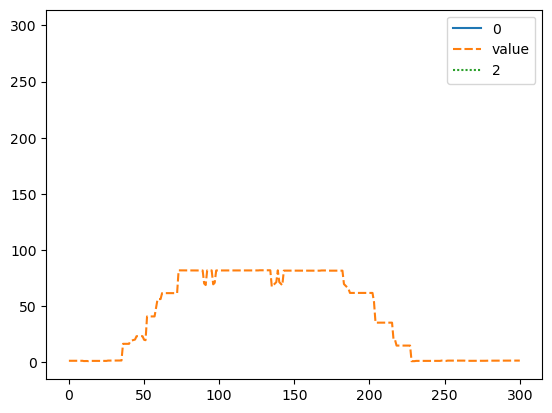

In [375]:
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output

for row in df.tail(1).itertuples():
    sns.lineplot(row)
    plt.show()


In [350]:
df4.tail(10)

,dim_0,class,length
290,0 1.947921 1 1.947921 2 1.94792...,0,301
291,0 1.947921 1 1.947921 2 1.94792...,0,301
292,0 1.947921 1 1.947921 2 1.94792...,0,301
293,0 1.947921 1 1.947921 2 2.00403...,0,301
294,0 1.947921 1 2.004037 2 2.04426...,0,301
295,0 2.004037 1 2.044266 2 2.08449...,0,301
296,0 2.044266 1 2.084494 2 2.12472...,0,301
297,0 2.084494 1 2.124723 2 2.41370...,0,301
298,0 2.124723 1 2.413703 2 2.09523...,0,301
299,0 2.413703 1 2.095235 2 2.05500...,0,301


In [349]:
from sktime.classification.kernel_based import RocketClassifier
from sktime.classification.hybrid import HIVECOTEV2

#classifier = RocketClassifier(n_jobs=8)
classifier_hive = HIVECOTEV2(n_jobs=8)
x_train, y_train = df4.iloc[:, :-2], df4["class"]
#classifier.fit(x_train,y_train)
classifier_hive.fit(x_train, y_train)


/opt/conda/lib/python3.10/site-packages/numba/core/ir_utils.py:2147: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'sorted_indicies' of function '_online_shapelet_distance'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../opt/conda/lib/python3.10/site-packages/sktime/transformations/panel/shapelet_transform.py", line 1472:
@njit(fastmath=True, cache=True)
def _online_shapelet_distance(series, shapelet, sorted_indicies, position, length):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/opt/conda/lib/python3.10/site-packages/numba/core/ir_utils.py:2147: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'sorted_indicies' of function '_online_shapelet_distance'.

For more information vis

HIVECOTEV2(n_jobs=8)

In [351]:
import pickle

filename = './work/models/hivecote_model.sav'
pickle.dump(classifier_hive, open(filename, 'wb'))

In [321]:
df3.head()
df3["length"] = df3.dim_0.map(len)

In [325]:
df4 = df3[df3["length"] <= 301]

In [376]:
df2.head()

,dim_0,class
0,0 1.574797 1 1.574797 2 1.57479...,0
1,0 1.574797 1 1.574797 2 1.57479...,0
2,0 1.574797 1 1.574797 2 1.57479...,0
3,0 1.574797 1 1.574797 2 1.57479...,0
4,0 1.574797 1 1.574797 2 1.57479...,0


In [377]:
x_test, y_test = df.iloc[:, :-1], df["class"]
x2_test, y2_test = df2.iloc[:, :-1], df["class"]

In [378]:
x2_test

,dim_0
0,0 1.574797 1 1.574797 2 1.57479...
1,0 1.574797 1 1.574797 2 1.57479...
2,0 1.574797 1 1.574797 2 1.57479...
3,0 1.574797 1 1.574797 2 1.57479...
4,0 1.574797 1 1.574797 2 1.57479...
...,...
295,0 1.211761 1 1.355675 2 1.35567...
296,0 1.355675 1 1.355675 2 1.35567...
297,0 1.355675 1 1.355675 2 1.35567...
298,0 1.355675 1 1.355675 2 1.35567...


In [379]:
y2_predict = classifier_hive.predict(x2_test)

/opt/conda/lib/python3.10/site-packages/numba/core/ir_utils.py:2147: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'sorted_indicies' of function '_online_shapelet_distance'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../opt/conda/lib/python3.10/site-packages/sktime/transformations/panel/shapelet_transform.py", line 1472:
@njit(fastmath=True, cache=True)
def _online_shapelet_distance(series, shapelet, sorted_indicies, position, length):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/opt/conda/lib/python3.10/site-packages/numba/core/ir_utils.py:2147: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'sorted_indicies' of function '_online_shapelet_distance'.

For more information vis

In [352]:
y_predict = classifier_hive.predict(x_test)

/opt/conda/lib/python3.10/site-packages/numba/core/ir_utils.py:2147: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'sorted_indicies' of function '_online_shapelet_distance'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../opt/conda/lib/python3.10/site-packages/sktime/transformations/panel/shapelet_transform.py", line 1472:
@njit(fastmath=True, cache=True)
def _online_shapelet_distance(series, shapelet, sorted_indicies, position, length):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/opt/conda/lib/python3.10/site-packages/numba/core/ir_utils.py:2147: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'sorted_indicies' of function '_online_shapelet_distance'.

For more information vis

In [380]:
from sklearn.metrics import accuracy_score

accuracy_score(y2_test, y2_predict)

0.49

<AxesSubplot: >

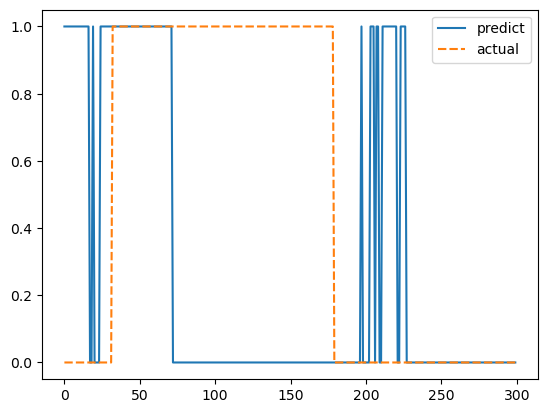

In [381]:
pd.Series(y_predict)


d = pd.DataFrame()
d["predict"] = pd.Series(y2_predict)
d["actual"] = y2_test
sns.lineplot(d)

In [356]:
y_test

0      0
1      0
2      0
3      0
4      0
      ..
295    0
296    0
297    0
298    0
299    0
Name: class, Length: 300, dtype: int64